# Computer Vision technique
Image taken from camera is a projection of 3D objects into 2D image, and this projection isn't perfect. This projection causes image distortion:
* it can change the apparent size of an object in an image (e.g object can appear smaller/bigger than the reality)
* it can change the apparent shape of an object in an image (e.g straight line can become a curvy line)
* it can cause an object's appearance/depth to change depending where it is in the field of view (e.g square near the edge of the image is disorted more than the one near centre)

Here is an example take from [here](http://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html)

<figure>
 <img src="assets/distortion_examples.png" width="380" alt="Distortion Examples" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Camera's distortion </p> 
 </figcaption>
</figure>

This notebook walks you through some technique to 

* calibrate camera
* correcting for distortion
* perspective transform

First let's import some modules

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

%matplotlib inline

## Calibrate camera
The first step is to calibrate camera, we will use chessboard to calibrate camera since it has regular hight constrat pattern make it's easy to detect automatically. We need at least 20 images to get a realiable calibration. We will use image from this [repository](https://github.com/udacity/CarND-Camera-Calibration)

The calibration include the following steps
1. load calibration images
2. find conners on the images
3. calibrate camera with given conners points
4. try undistort a test image

(1280, 960)


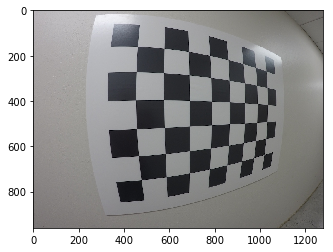

In [119]:
NX = 8 # the number of inside corners in x
NY = 6 # the number of inside corners in y

# list calibration images
def list_imgs():
    return glob.glob('./assets/cam_wide/GOPR*.jpg')

calib_imgs = list_imgs()

calib_imgs = np.sort(calib_imgs)

img = mpimg.imread(calib_imgs[0])
_ = plt.imshow(img)

H, W, C = img.shape
IMG_CV_SHAPE = (W, H)

print(IMG_CV_SHAPE)

Next is to create images points and object points:

* images points is inner conner points of the image can be computed via `cv2.findChessboardCorners`
* object points is fixed point [x,y] for x=0,...,7 and y = 0,...,5

This is implemented in the following function `get_img_obj_points`

In [120]:
# find conners and draw conners on the image
def find_conners(bgr, nx=NX, ny=NY):
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    #print (gray.shape, gray.shape[::-1])
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # cv2.drawChessboardCorners(rgb, (nx, ny), corners, ret)
    return ret, corners

def get_img_obj_points(imgs, nx, ny):
    imgs_points = []
    obj_points = []
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    
    for img in imgs:
        bgr = cv2.imread(img)
        ret, conners = find_conners(bgr, nx, ny)
        if (ret):
            imgs_points.append(conners)
            obj_points.append(objp)
           
    return imgs_points, obj_points

Now let's calibrate the camera with `cv2.calibrateCamera`

In [121]:
# get images-point and object-points
imgs_points, obj_points = get_img_obj_points(calib_imgs, nx, ny)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, imgs_points, IMG_CV_SHAPE, None, None)

## Correcting for distortion

Given our camera is calibrated where

* mtx: is the camera matrix of size 3x3
* dist: is the distortion coefficients
* rvecs: is the rotation vectors
* tvecs: is the translation vectors

We can use `cv2.undistort` to undistort a test image

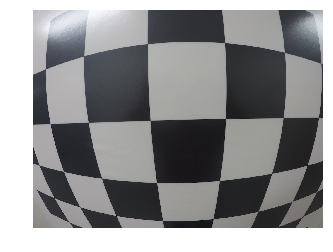

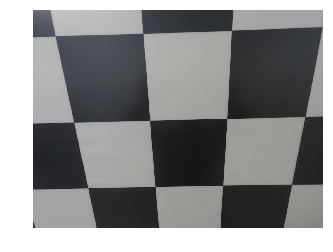

In [116]:
def show_img(img, label, ax = None):
    '''
    this function show image & label
    '''
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    
    # draw image
    if label is not None:
        ax.text(0, 0, label, color='k',backgroundcolor='c', fontsize=10)
    
    ax.imshow(img)
    ax.axis('off')

def view_imgs(imgs, labels, figsize, multi_col = True, sharex = True, sharey = True):
    nrows = 1 if multi_col else len(labels)
    ncols = len(labels) if multi_col else 1
    fig, axes = plt.subplots(figsize= figsize, nrows=nrows, ncols=ncols, sharey=sharex, sharex=sharey)
    for i, ax in enumerate(axes.flatten()):
        show_img(imgs[i], labels[i], ax)

test_img = mpimg.imread('./assets/cam_wide/test_image.jpg')
undist_img = cv2.undistort(test_img, mtx, dist, None, mtx)

show_img(test_img, None)
show_img(undist_img, None)

## Perspective transform

When we want to view an object from a different angle or direction, we use perspective transform which has following steps
1. undistort the image
2. convert to gray scale
3. find the chessboard corners
4. define 4 source points (outer 4 corners from above) and define 4 destination points
5. use `cv2.getPerspectiveTransform` to get the transformation matrix
6. use `cv2.warpPerspective` to apply the perspective transform

In [ ]:
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    # 2) Convert to grayscale
    # 3) Find the chessboard corners
    # 4) If corners found: 
            # a) draw corners
            # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
            # e) use cv2.warpPerspective() to warp your image to a top-down view
    #delete the next two lines
    H, W, _ = img.shape
    undistort_img = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undistort_img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret:
    
        cv2.drawChessboardCorners(undistort_img, (nx, ny), corners, ret)
        src_points = corners[[0,7,40,47]]
        des_point = np.float32([[50,50],[W-50, 50],[50, H-50],[W-50, H-50]])
        M = cv2.getPerspectiveTransform(src_points, des_point)
        warped = cv2.warpPerspective(undistort_img, M, (W,H), flags=cv2.INTER_LINEAR) 
    else:
        M = None
        warped = np.copy(img) 
    return warped, M

Let's test perspective transform on an image

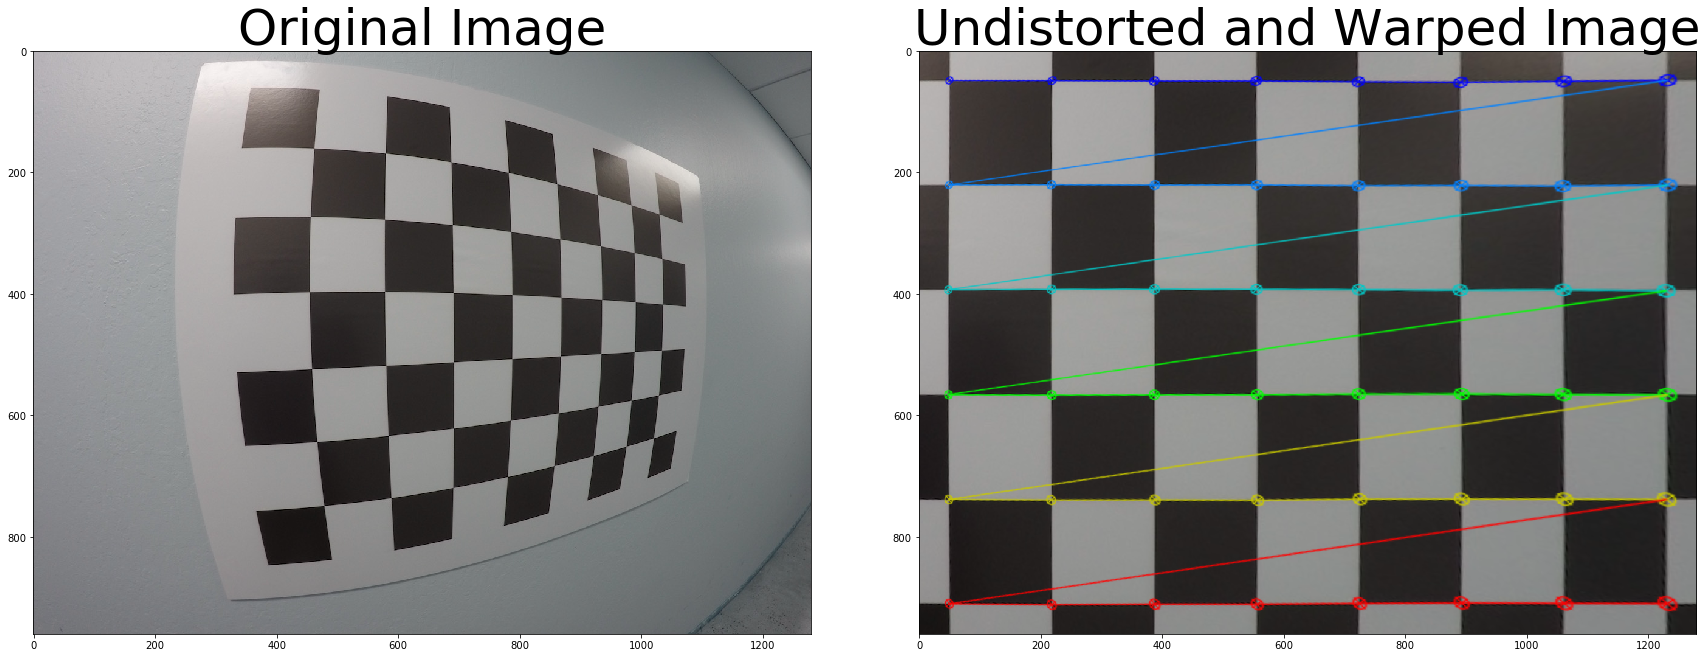

In [122]:
img = cv2.imread(calib_imgs[0])
top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)